<a href="https://colab.research.google.com/github/l-monninger/ahl/blob/main/ahl_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matching Patents to Scientific Papers
In this Colab notebook, we will be walking through our team's endeavors to provide a model for **matching patents with scientific papers.** 

## Motivation
The original motivation behind this project was to create a recommendation system that **given a patent would recommend a list of scientific papers, and vice versa.** We anticipated this could serve as the first steps in development of a tool that would be useful for researchers, technologists, and practitioners of patent law.

## Difficulties
Difficulties encountered primarily stemmed from the **size of the data** with respect to the processing attempted. Our greedy methods required an expensive Cartesian product. Our regressive methods required a large number of input features. And, when recommending, we used naive algorithms that required full reprojection of the data.

Difficulties at scale noted, we will generally be operating over random samples of the data in this notebook--or else rely on lazy evaluation to avoid high runtimes.

In several sections, a **POC (proof of concept) cell** will be provided first before a more extensive version of the same logic.

## Exploration
Our data exploration focused on the word counts

## Models


## Application
A deployed demo version of the resulting models can be found at: https://patp2pat.com

## Requirements

### Installations

In [1]:
# Installation 
!pip install kaggle
!pip install pyspark
!pip install feedparser
!pip install torch
!pip install sentence-transformers
!pip install numpy
!pip install rake-nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=abf7843d4d7d5ea08bd2fc77704de61ab49995fe26ee0f265e72b342b0fbbc2c
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=da780c7649a797a021e580e88cb5eae9e718d15e7c2327807887b7184a99d971
  Stored in

### Encoding

In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

### Libraries

In [3]:
# libraries
import json
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import * 
import requests
from lxml import etree
import nltk
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from rake_nltk import Rake
import csv
import seaborn as sns

#import libraries for knowledge graph
import re
import bs4
import requests
import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
from tqdm import tqdm
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from collections import Counter
from typing import *

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sentence_transformers import SentenceTransformer

### Mount on Drive

In [4]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle

Mounted at /content/drive


### Configure Kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

### Configure Spark

In [6]:
# start sparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()

### GPU


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Common Helper Funcs


#### Tokenization

##### NLTK Dependencies

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

##### Stopwords

In [9]:
stopwords : set[str] = set(nltk.corpus.stopwords.words('english'))

def tokenize_non_stopwords(content : str)->list[str]:
  """Tokenizes content excluding the stopwords.

  Args:
      content (str): _description_

  Returns:
      list[str]: _description_
  """
  tokens = nltk.word_tokenize(content)
  words = [
      token.lower() 
      for token in tokens 
      if token.isalpha() and token.lower() not in stopwords
  ]
  return words

In [10]:
tokenize_non_stopwords_udf = udf(tokenize_non_stopwords, ArrayType(StringType()))

##### Sentences

In [11]:
def tokenize_sentences(content : str)->list[str]:
  """Tokenizes sentences.

  Args:
      content (str): _description_

  Returns:
      list[str]: _description_
  """
  return nltk.sent_tokenize(content)

In [12]:
tokenize_sentences_udf = udf(tokenize_sentences, ArrayType(StringType()))

##### Named entities

In [13]:
def get_named_entities_in_sentence(sentence):
  chunked = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sentence)))
  return [ 
      " ".join(w for w, t in elt) 
      for elt in chunked if isinstance(elt, nltk.Tree) 
  ]

def get_named_entities(content):
  sentences = tokenize_sentences(content)
  sentence_nes = [get_named_entities_in_sentence(sentence) for sentence in sentences]
  return [ne for nes in sentence_nes for ne in nes]

In [14]:
get_named_entities_udf = udf(get_named_entities, ArrayType(StringType()))

##### Rake

In [15]:
def get_rake(content, *, min_len : int = 3):
  r = Rake()
  r.extract_keywords_from_text(content)
  keywords = r.get_ranked_phrases()
  words = [
    token.lower() 
    for token in keywords 
      if token.isalpha() and token.lower() not in stopwords and len(token)>= min_len
  ]
  return words

In [16]:
get_rake_udf = udf(get_rake, ArrayType(StringType()))

##### Top tokens

In [17]:
def get_top_tokens(tokens, *, size : int = 10):
  return [
      token
      for token, _ in Counter(tokens).most_common(size)
  ]

In [18]:
tokenize_top_10_udf = udf(get_top_tokens, ArrayType(StringType()))

#### Ngrams


In [19]:
Ngram = Tuple[Tuple[str], str]

##### Prefix ngrams

In [20]:
def get_sequence_prefix_ngrams(*,
    seq : Sequence,
    context_size : int,
)->Iterable[Ngram]:

  for i in range(context_size, len(seq)):
      yield  (
          [seq[i - j - 1] for j in range(context_size)],
          seq[i]
      )

def get_text_prefix_ngrams(*, 
  text: str, 
  context_size: int, 
  tokenize : Callable[[str], Iterable[str]] = tokenize_non_stopwords
) -> Iterable[Ngram]:
        
  sentence = tokenize(text)
  
  for ngram in get_sequence_prefix_ngrams(
    seq = sentence,
    context_size = context_size
  ): yield ngram

In [21]:
assert list(get_text_prefix_ngrams(
    text="Hello, my name is Liam.",
    context_size=2,
)) == [(['name', 'hello'], 'liam')]

##### Excluding ngrams

In [22]:
def sequence_excluding(*,
    seq : Sequence,
    excluding_pos : int,
    context_size : int,
    fill_term : Any       
):

  context = []
  i = excluding_pos - context_size

  while i < 0: 
    context.append(fill_term)
    i+=1

  while i < excluding_pos and i < len(seq):
    context.append(seq[i])
    i +=1
  i+=1

  while i < len(seq):
    context.append(seq[i])
    i += 1

  while len(context) < 2 * context_size:
    context.append(fill_term)
    i+=1

  return context[0:2*context_size]
  

def get_sequence_excludes_ngrams(*,
    seq : Sequence,
    context_size : int,
    fill_term : Any  
)->Iterable[Ngram]:

  for i in range(0, len(seq)):
      yield  (
          sequence_excluding(
              seq = seq,
              excluding_pos = i,
              context_size = context_size,
              fill_term = fill_term
          ),
          seq[i]
      )

def get_text_excludes_ngrams(*, 
  text: str, 
  context_size: int, 
  tokenize : Callable[[str], Iterable[str]] = tokenize_non_stopwords,
  fill_term : str = ""
) -> Iterable[Ngram]:
        
  sentence = tokenize(text)
  
  for ngram in get_sequence_excludes_ngrams(
    seq = sentence,
    context_size = context_size,
    fill_term=fill_term
  ): yield ngram


In [23]:
assert list(get_text_excludes_ngrams(
    text="Hello, my name is Liam.",
    context_size=2,
)) == [(['', '', 'name', 'liam'], 'hello'),
 (['', 'hello', 'liam', ''], 'name'),
 (['hello', 'name', '', ''], 'liam')]

##### Default ngram embedding model

In [24]:
class NgramModel(nn.Module):
        
    def __init__(self, *, vocab_size : int, embedding_dim : int, context_size : int):
        super(NgramModel, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.activate = nn.Sequential(
            self.embeddings,
            nn.Flatten(0),
            nn.Linear(context_size * embedding_dim, 128),
            nn.ReLU(), # first
            nn.Linear(128, vocab_size),
            nn.LogSoftmax(0),
            nn.Unflatten(0, (1, vocab_size))
        )
        
    def forward(self, inputs):
        return self.activate(inputs)

#### Vocabulary


A vocabulary is a mapping from words to contiguous indices and back to words.

In [25]:
Vocab = Tuple[Dict[Any, int], Dict[int, Any]]

##### Corpus

In [26]:
def corpus_to_words(*, 
      texts: Iterable[str],
      tokenize_sentences : Callable[[str], Iterable[str]] = tokenize_sentences,
      tokenize_words : Callable[[str], Iterable[str]] = tokenize_non_stopwords
)->Iterable[str]:

  for text in texts:
      for s in tokenize_sentences(text):
        sentence = tokenize_words(text)
        for word in sentence: yield word

In [27]:
assert list(corpus_to_words(texts=[
    "Liam runs to the store.",
    "Liam finds an egg.",
    "Liam cooks the egg."
])) == ['liam', 'runs', 'store', 'liam', 'finds', 'egg', 'liam', 'cooks', 'egg']

##### All word vocabulary

In [28]:
def get_texts_vocab(*, 
      texts: Iterable[str],
      tokenize_sentences : Callable[[str], Iterable[str]] = tokenize_sentences,
      tokenize_words : Callable[[str], Iterable[str]] = tokenize_non_stopwords
) -> Vocab:
        
  vocab = { "" : 0}
  pos = 1
  for text in texts:
      for s in tokenize_sentences(text):

          sentence = tokenize_non_stopwords(text)
          # add individual words to vocab
          for word in sentence:
              if word in vocab:
                  continue
              vocab[word] = pos
              pos += 1
              
  inv_vocab = {v: k for k, v in vocab.items()}
  return (vocab, inv_vocab)

In [29]:
assert list(get_texts_vocab(texts=[
    "Liam runs to the store.",
    "Liam finds an egg.",
    "Liam cooks the egg."
])) == [{'': 0, 'liam': 1, 'runs': 2, 'store': 3, 'finds': 4, 'egg': 5, 'cooks': 6},
 {0: '', 1: 'liam', 2: 'runs', 3: 'store', 4: 'finds', 5: 'egg', 6: 'cooks'}]

##### Top word vocabulary

In [30]:
def get_texts_top_vocab(*, 
      texts: Iterable[str],
      size : int = 1_000, 
      tokenize_sentences : Callable[[str], Iterable[str]] = tokenize_sentences,
      tokenize_words : Callable[[str], Iterable[str]] = tokenize_non_stopwords,
) -> Vocab:
        
  top_tokens = get_top_tokens(corpus_to_words(
      texts=texts,
      tokenize_sentences=tokenize_sentences,
      tokenize_words=tokenize_words
    ), size=size)
 
  vocab = { "" : 0}
  for i, token in enumerate(top_tokens): vocab[token] = i + 1
              
  inv_vocab = {v: k for k, v in vocab.items()}
  return (vocab, inv_vocab)

In [31]:
assert list(get_texts_top_vocab(texts=[
    "Liam runs to the store.",
    "Liam finds an egg.",
    "Liam cooks the egg."
], size=2)) == [{'' : 0, 'liam': 1, 'egg': 2}, {0 : '', 1: 'liam', 2: 'egg'}]

#### Filling and slicing

In [32]:
def flice_text(text : str, *,  max_length : int, fill_str : str)->str:
    
    if len(text) >= max_length:
        return text[0:max_length]
    
    cpy = text
    while len(cpy) < max_length:
        cpy += fill_str
    return cpy

def flice_list(text : List[Any], *,  max_length : int, fill_term : Any)->List[Any]:
    
    if len(text) >= max_length:
        return text[0:max_length]
    
    cpy = text
    while len(cpy) < max_length:
        cpy.append(fill_term)
    return cpy

#### Embedding

##### Ngram embedding

In [33]:
Embedding = Callable[[Any], torch.FloatTensor]

In [34]:
def train_ngram_embedding(
    *, 
    epochs : int = 10,
    embedding_dim : int = 32,
    context_size : int = 3,
    ngrams : Callable[[], Iterable[Ngram]],
    vocab : Vocab
)->Tuple[Embedding, List[float]]:
  
        vocab_forward, vocab_reverse = vocab
        losses = []
        
        # model
        loss_function = nn.NLLLoss()
        model = NgramModel(
            vocab_size=len(vocab_forward), 
            embedding_dim=embedding_dim, 
            context_size=context_size
        )
        optimizer = optim.SGD(model.parameters(), lr=0.001)

        # train
        for epoch in range(epochs):
    
            epoch_loss = 0
            i = 0
            for context, target in ngrams():

                i+=1
                # words to indices
                context_idxs = torch.tensor([vocab_forward[w] for w in context], dtype=torch.long)

                # zero out the gradient
                model.zero_grad()

                # forward pass
                log_probs = model(context_idxs)

                # loss
                loss = loss_function(log_probs, torch.tensor([vocab_forward[target]], dtype=torch.long))

                # backward pass
                loss.backward()
                optimizer.step()

                # Get the Python number from a 1-element Tensor by calling tensor.item()
                epoch_loss += loss.item()
            losses.append(epoch_loss)

        # factory
        def embedding(input : Any)->torch.FloatTensor():
          # try:
          return model.embeddings.weight[vocab_forward[input]]
          # except Exception as e:
          # return torch.zeros(embedding_dim)

        sim = nn.CosineSimilarity()
        # values, indices = sim(model.embeddings.weight[vocab["data"]], model.embeddings.weight).sort(descending=True)

        return (embedding, losses, model, model.embeddings.weight)

## Data Wrangling

### Download and Spark frames

##### Papers

In [35]:
!kaggle datasets download -d Cornell-University/arxiv --force
!unzip -o /content/arxiv.zip

100% 1.14G/1.14G [01:00<00:00, 21.8MB/s]
100% 1.14G/1.14G [01:00<00:00, 20.3MB/s]
Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [36]:
arxiv_sdf = spark.read.json("arxiv-metadata-oai-snapshot.json", multiLine = False, primitivesAsString = True)

In [37]:
arxiv_sdf.show()

+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|            abstract|             authors|      authors_parsed|       categories|            comments|                 doi|       id|         journal-ref|             license|           report-no|         submitter|               title|update_date|            versions|
+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+---------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+--------------------+
|  A fully differe...|C. Bal\'azs, E. L...|[[Balázs, C., ], ...|           hep-ph|37 pages, 15 figu...|10.1103/PhysRevD....|0704.0001|Phys.Rev.D76:0130...|                null|    ANL-HEP

##### Patents

In [38]:
!kaggle datasets download -d jackchungchiehyu/big-patent
!unzip -o /content/big-patent.zip

100% 2.46G/2.46G [02:07<00:00, 24.1MB/s]
100% 2.46G/2.46G [02:07<00:00, 20.8MB/s]
Archive:  /content/big-patent.zip
  inflating: train/train/a/data000000000000  
  inflating: train/train/a/data000000000001  
  inflating: train/train/a/data000000000002  
  inflating: train/train/a/data000000000003  
  inflating: train/train/a/data000000000004  
  inflating: train/train/a/data000000000005  
  inflating: train/train/a/data000000000006  
  inflating: train/train/a/data000000000007  
  inflating: train/train/a/data000000000008  
  inflating: train/train/a/data000000000009  
  inflating: train/train/a/data000000000010  
  inflating: train/train/a/data000000000011  
  inflating: train/train/a/data000000000012  
  inflating: train/train/a/data000000000013  
  inflating: train/train/a/data000000000014  
  inflating: train/train/a/data000000000015  
  inflating: train/train/a/data000000000016  
  inflating: train/train/a/data000000000017  
  inflating: train/train/a/data000000000018  
  inflatin

In [39]:
train_patents_sdf = spark.read.json("train/train/*/data*")

In [40]:
train_patents_sdf.show()

+--------------------+------------------+--------------------+------------------+
|            abstract|application_number|         description|publication_number|
+--------------------+------------------+--------------------+------------------+
|a probe for detec...|     US-76085585-A|referring now to ...|      US-4680475-A|
|an image forming ...|     US-32365908-A|in describing emb...|  US-2009136245-A1|
|a vibrating trans...|     US-92269486-A|referring now to ...|      US-4872335-A|
|the present inven...|     US-26698508-A|as used herein a ...|  US-2009176244-A1|
|an imaging record...|     US-40116089-A|referring now to ...|      US-4978974-A|
|apparatus for obt...|     US-18070180-A|the invention rev...|      US-4329043-A|
|liquid developers...|     US-82413577-A|liquid electrogra...|      US-4170563-A|
|an apparatus for ...|     US-34700903-A|the present inven...|     US-7246255-B1|
|apparatus for con...| US-201514979602-A|in the detailed d...|  US-2017188019-A1|
|a thread has a 

### Paper categories
We need to retrieve the paper categories.

#### Parse the categories from the existing data frame

In [41]:
arxiv_sdf = arxiv_sdf.withColumn('categories_parsed', split(arxiv_sdf['categories'], ' '))

In [42]:
arxiv_sdf.select('categories_parsed').show(5)

+------------------+
| categories_parsed|
+------------------+
|          [hep-ph]|
|  [math.CO, cs.CG]|
|  [physics.gen-ph]|
|         [math.CO]|
|[math.CA, math.FA]|
+------------------+
only showing top 5 rows



#### Fetch category taxonomy from arxiv site

In [43]:
category_id_to_category = {}
category_id_to_category ['cs'] = 'Computer Science'
category_id_to_category ['econ'] = 'Economics'
category_id_to_category ['eess'] = 'Electrical Engineering and Systems Science'
category_id_to_category ['math'] =  'Mathematics'
category_id_to_category ['astro-ph'] = 'Astrophysics'
category_id_to_category ['cond-mat'] = 'Condensed Matter'
category_id_to_category ['gr-qc'] = 'General Relativity and Quantum Cosmology'
category_id_to_category ['hep-ex'] =  'High Energy Physics - Experiment'
category_id_to_category ['hep-lat'] = 'High Energy Physics - Lattice'
category_id_to_category ['hep-ph'] =  'High Energy Physics - Phenomenology'
category_id_to_category ['hep-th'] = 'High Energy Physics - Theory'
category_id_to_category ['math-ph'] = 'Mathematical Physics'
category_id_to_category ['nlin'] = 'Nonlinear Sciences'
category_id_to_category ['nucl-ex'] = 'Nuclear Experiment'
category_id_to_category ['nucl-th'] =  'Nuclear Theory'
category_id_to_category ['physics'] = 'Physics'
category_id_to_category ['quant-ph'] = 'Quantum Physics'
category_id_to_category ['q-bio'] = 'Quantitative Biology'
category_id_to_category ['q-fin'] = 'Quantitative Finance'
category_id_to_category ['stat'] = 'Statistics'

In [44]:
arxiv_taxonomy_url = "https://arxiv.org/category_taxonomy"

response = requests.get(arxiv_taxonomy_url)

arxiv_categories_df = pd.DataFrame(columns=[
    'id', 
    'category_id', 
    'sub_category_id', 
    'category',
    'sub_category'
])
categories = []

if response.status_code == 200: # this does have a tendency to 403
    parser = etree.HTMLParser()
    tree = etree.fromstring(response.content, parser=parser)

    for x, y in zip(tree.xpath("//*[@id='category_taxonomy_list']//h4/text()"), tree.xpath("//*[@id='category_taxonomy_list']//h4/span/text()")):
      
      id = x.strip()
      split = id.split(".")
      category_id = (split[0:1] or ["none"])[0]
      subcategory_id = (split[1:2] or [category_id])[0]
      category = category_id_to_category.get(category_id, "none")
      sub_category = y.strip("()").strip()

      arxiv_categories_df = pd.concat([arxiv_categories_df, pd.DataFrame({
          'id': [id], 
          'category_id' : [category_id], 
          'sub_category_id' : [subcategory_id], 
          'category' : category,
          'sub_category': [sub_category],
      })], ignore_index=True)
    
    categories = tree.xpath("//*[@id='category_taxonomy_list']/h2/text()") + tree.xpath("//*[@id='category_taxonomy_list']//h3/text()")

arxiv_categories_df = arxiv_categories_df.set_index("id")

In [45]:
arxiv_categories_df

,category_id,sub_category_id,category,sub_category
id,,,,
cs.AI,cs,AI,Computer Science,Artificial Intelligence
cs.AR,cs,AR,Computer Science,Hardware Architecture
cs.CC,cs,CC,Computer Science,Computational Complexity
cs.CE,cs,CE,Computer Science,"Computational Engineering, Finance, and Science"
cs.CG,cs,CG,Computer Science,Computational Geometry
...,...,...,...,...
stat.CO,stat,CO,Statistics,Computation
stat.ME,stat,ME,Statistics,Methodology
stat.ML,stat,ML,Statistics,Machine Learning


#### Separate categories and subcategories in arxiv_sdf

In [46]:
arxiv_categories_dict = arxiv_categories_df.to_dict()

def get_categories(parsed_categories : list[str])->list[str]:
  return [*set([
      arxiv_categories_dict.get(
          "category_id",
          {}
      ).get(category, "")
      for category in parsed_categories
  ])]

def get_subcategories(parsed_categories : list[str])->list[str]:
  return [*set([
       arxiv_categories_dict.get(
          "sub_category_id",
          {}
      ).get(category, "")
      for category in parsed_categories
  ])]


get_categories_udf = udf(get_categories, ArrayType(StringType()))
get_subcategories_udf = udf(get_subcategories, ArrayType(StringType()))

In [47]:
arxiv_sdf = arxiv_sdf.withColumn('categories_final', get_categories_udf(col("categories_parsed")))
arxiv_sdf = arxiv_sdf.withColumn('subcategories_final', get_subcategories_udf(col("categories_parsed")))

In [48]:
arxiv_sdf.select('categories_final', 'subcategories_final').show(5)

+----------------+-------------------+
|categories_final|subcategories_final|
+----------------+-------------------+
|        [hep-ph]|           [hep-ph]|
|      [math, cs]|           [CG, CO]|
|       [physics]|           [gen-ph]|
|          [math]|               [CO]|
|          [math]|           [FA, CA]|
+----------------+-------------------+
only showing top 5 rows



### Data helpers and loaders

#### Papers

#### Patents

#### Papers and patents


## Exploratory Data Analysis


### Paper categories and embedding

This section is intended to preface the endeavors below. In short, we want to make it clear the custom embedding is costly, and not always fruitful, hence our exploration 🙃

We will be adopting a fairly straightforward premise: the list of subcategories in `arxiv_sdf` can be thought of as a list of tokens. When there is only one parent category, the relationship between the subcategory tokens should usually be one to many. Therefore, we should expect substantial clustering of subcategory embeddings with respect to their parent categories.

However, as we believe is demonstated below, computing these embeddings is (a) expensive and (b) prone to bias over small vocabularies. This puts us between a rock and hard place for training an effective embedding ourselves. However, we do attempt one further below in our models section.

#### Embedding sample pipeline

In [49]:
SUBCATEGORY_DISTANCE_CONTEXT_SIZE = 2 # this is two sided
SUBCATEGORY_DISTANCE_SAMPLE_RATE = .01

# this sample is expensive to compute, so we'll only do it once
# plus, it gets collected in memory either way
arxiv_subcategory_embedding_sample_df = arxiv_sdf.select(
    "subcategories_final"
  ).filter(
      size("subcategories_final") > 0
  ).filter(
      size("categories_final") < 2
  ).sample(
      SUBCATEGORY_DISTANCE_SAMPLE_RATE
).collect()

def yield_subcategories():
   for row in arxiv_subcategory_embedding_sample_df: yield row[0]

def get_arxiv_subcategories_vocab():
  vocab = {"":0}
  pos = 1
  for i in set(arxiv_categories_df["sub_category_id"]):
    vocab[i] = pos
    pos += 1
  inv_vocab = {v: k for k, v in vocab.items()}
  return (vocab, inv_vocab)


# we'll recompute the ngrams in an generator
# that way the memory footpring stays relatively small
def yield_subcategories_ngrams():
  for sub in yield_subcategories():
    for ngram in get_sequence_excludes_ngrams(
        seq=sub, 
        context_size=SUBCATEGORY_DISTANCE_CONTEXT_SIZE, 
        fill_term=""
):
      yield ngram

#### Train embedding

In [50]:
vocab = get_arxiv_subcategories_vocab()
vocab_forward, vocab_back = vocab
ngrams = yield_subcategories_ngrams

embedding, loss, weights, model = train_ngram_embedding(
    epochs=20,
    embedding_dim=64,
    context_size=2*2,
    ngrams=ngrams,
    vocab=vocab
)

#### Plotting subcategories by embedding and parent category

Ultimately, what we get as a result of this limited training does not appear all that powerful. We would perhaps naively expect our categories to appear more frequently alongside others in their same overarching discipline, and thus have close embeddings. But, this is not the case.

We use the table 

As will be discussed elsewhere in this notebook, we believe the primary limitation is the data and training. However, it is important to note.

In [51]:
ahl_category = {
    
    # economics
    'Quantitative Finance' : "Economics",
    'Economics' : "Economics",
    
    # biology
    'Quantitative Biology' : "Biology",
    
    # informatics
    'Computer Science' : "Informatics",
    'Statistics' : "Informatics",
    'Nonlinear Sciences' : "Informatics",
    'Electrical Engineering and Systems Science' : "Informatics",
  
    # math
    'Mathematical Physics' : "Math",
    'Mathematics' : "Math",

    # physics
    'Nuclear Experiment' : "Physics",
    'Nuclear Theory' : "Physics",
    'Physics' : "Physics",
    'Quantum Physics' : "Physics",
    'Astrophysics' : "Physics",
    'High Energy Physics - Experiment' : "Physics",
    'High Energy Physics - Lattice' : "Physics",
    'High Energy Physics - Phenomenology' : "Physics",
    'High Energy Physics - Theory' : "Physics",
    'General Relativity and Quantum Cosmology' : "Physics",

}

<ipython-input-52-f602dcd025f5>:24: UserWarning: 
The palette list has fewer values (12) than needed (20) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(frame, x="x", y="y", hue="category", palette=sns.color_palette("Paired"))


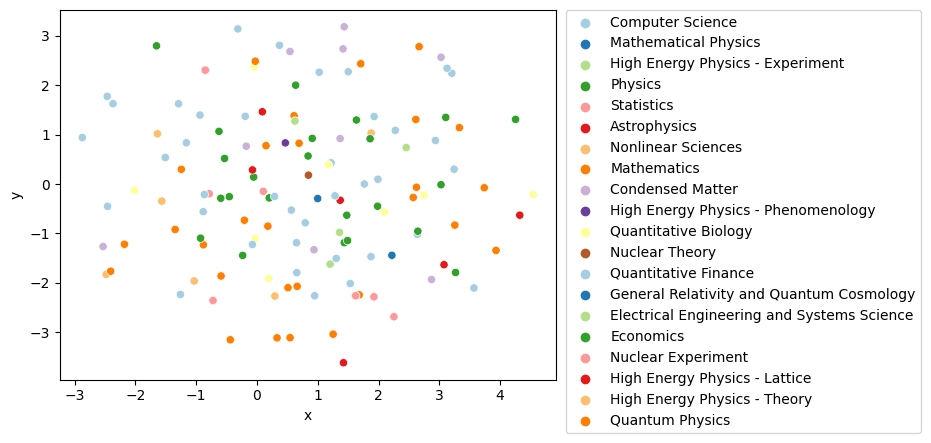

In [52]:
M =[]
for key in vocab_forward:
  M.append(embedding(key).detach().numpy())

M = np.array(M)
t = TSNE(random_state=42).fit_transform(M).transpose()

# YOU can do roughly the same thing with PCA
# pca = PCA(n_components=2)
# reduced = pca.fit_transform(M)
# t = reduced.transpose()

frame = pd.DataFrame()
frame["sub_category_id"] = list(vocab_forward.keys())
frame["x"] = t[0]
frame["y"] = t[1]
frame = frame.merge(arxiv_categories_df[["category", "sub_category_id"]], on="sub_category_id")  

def get_ahl_category(category : str):
  return ahl_category.get(category, "None")

frame["AHL Category"] = frame["category"].apply(get_ahl_category)

scatter = sns.scatterplot(frame, x="x", y="y", hue="category", palette=sns.color_palette("Paired"))
scatter.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

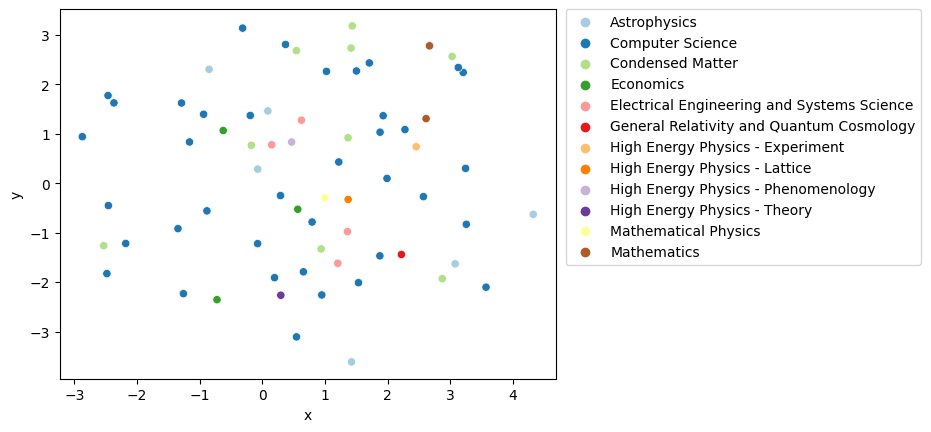

In [53]:
ordered_frame = frame.sort_values(["category"])
scatter = sns.scatterplot(ordered_frame.iloc[0:70], x="x", y="y", hue="category", palette=sns.color_palette("Paired"))
scatter.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<ipython-input-54-db8f35982c1f>:1: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  scatter = sns.scatterplot(ordered_frame.iloc[70:], x="x", y="y", hue="category", palette=sns.color_palette("Paired"))


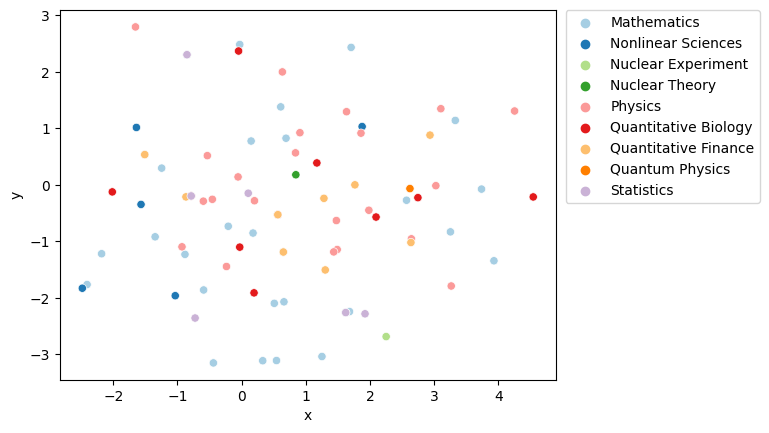

In [54]:
scatter = sns.scatterplot(ordered_frame.iloc[70:], x="x", y="y", hue="category", palette=sns.color_palette("Paired"))
scatter.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<Axes: title={'center': 'Embedding Loss by Epoch'}, xlabel='No. Epochs', ylabel='Loss (NLLoss)'>

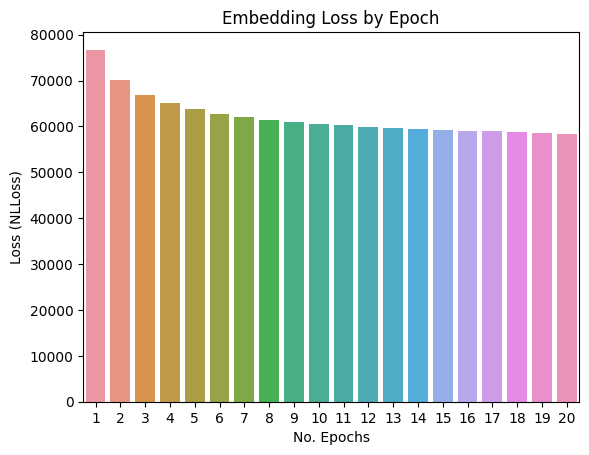

In [55]:
epoch_accuracy = sns.barplot(
  x=list(range(1, len(loss) + 1)),
  y=loss
)
sns.set(rc={"figure.figsize":(12, 7)}, font_scale=1)
epoch_accuracy.set_ylim(0, )
epoch_accuracy.set(xlabel='No. Epochs', ylabel='Loss (NLLoss)', 
        title='Embedding Loss by Epoch')
epoch_accuracy

### Word tokens

As custom embeddings weren't initially very fruitful, let's take things back a step. We can perhaps do something simpler to first connect different papers and then patents. The simpler approach may be to just look for tokens that intersect.

Here again we'll demonstrate that compute becomes a problem rather quickly. And, furthermore, that this solution does best when used with other NLP models, namely, a named entity extractor.

#### Pulling into memory

We're now going to pull a couple frames into memory, to help generate some word clouds and later perform our cross join. This will be much easier with a smaller dataset. Here we're less interested in getting a summary of our entire dataset, and more interested in the kinds of tokens we produce with each method.

In [56]:
ARXIV_IN_MEM_SAMPLE_RATE = .001

arxiv_tokens_sdf = arxiv_sdf.sample(ARXIV_IN_MEM_SAMPLE_RATE).select(
    [
        "id", "abstract", "title", "categories_final", "subcategories_final"
    ]
)

In [57]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
arxiv_tokens_pd = pd.DataFrame.from_records(arxiv_tokens_sdf.collect(), columns=arxiv_tokens_sdf.columns)
# arxiv_tokens_sdf.collect()

#### Simple token extraction

To start off, we're simply going to add some token arrays to our Arxiv papers dataset. 

In [58]:
arxiv_tokens_pd["abstract_tokens"] = arxiv_tokens_pd["abstract"].apply(tokenize_non_stopwords)
arxiv_tokens_pd["abstract_top_tokens"] = arxiv_tokens_pd["abstract_tokens"].apply(get_top_tokens)
arxiv_tokens_pd["abstract_ne"] = arxiv_tokens_pd["abstract"].apply(get_named_entities) # most expensive
arxiv_tokens_pd["abstract_rake_tokens"] = arxiv_tokens_pd["abstract"].apply(get_rake)

In [59]:
arxiv_tokens_pd

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens
0,0704.0092,We study a recently proposed formulation of ...,Energy density for chiral lattice fermions wit...,"[hep-ph, hep-lat]","[hep-ph, hep-lat]","[study, recently, proposed, formulation, overl...","[overlap, fermions, density, chemical, potenti...",[],"[temperature, study, shown, particular, functi..."
1,0704.0427,We study the critical behavior of the three-...,The 3D +-J Ising model at the ferromagnetic tr...,[cond-mat],"[stat-mech, dis-nn]","[study, critical, behavior, j, ising, model, p...","[p, critical, j, ising, xy, transition, behavi...","[Nishimori, Monte Carlo, p_N]","[transition, randomly, three, three, study, re..."
2,0704.2537,"Masses of pseudoscalar and vector mesons, wh...",Calculation of pseudoscalar and vector mesons'...,[hep-ph],[hep-ph],"[masses, pseudoscalar, vector, mesons, ground,...","[quarks, pseudoscalar, vector, mesons, antiqua...",[],"[quarks, spin, values, shown, reduce, quasi, p..."
3,0704.3268,An easily implementable path solution algori...,2D Path Solutions from a Single Layer Excitabl...,[cs],"[NE, RO]","[easily, implementable, path, solution, algori...","[network, model, also, related, path, algorith...","[CNN, CMOS]","[model, also, network, network, excitable, pre..."
4,0705.0252,We consider power allocation algorithms for ...,Power Allocation for Discrete-Input Non-Ergodi...,"[math, cs]",[IT],"[consider, power, allocation, algorithms, tran...","[power, optimal, schemes, allocation, constrai...","[Optimal, SNR, Singleton]","[short, long, shown, show, prohibitive, non, n..."
...,...,...,...,...,...,...,...,...,...
2239,quant-ph/0508136,The thermodynamical properties of a quantize...,Thermodynamics of a quantized electromagnetic ...,[quant-ph],[quant-ph],"[thermodynamical, properties, quantized, elect...","[obtain, divergences, temperature, effects, th...",[Casimir],"[vanishing, vacuum, uniqueness, source, pressu..."
2240,quant-ph/0607071,We consider the propagation of polarized pho...,Tests of Complete Positivity in Fiber Optics,"[quant-ph, cond-mat, hep-th]","[other, quant-ph, hep-th]","[consider, propagation, polarized, photons, op...","[polarization, consider, propagation, polarize...",[],"[ups, time, situation, show, propagation, pres..."
2241,quant-ph/0608098,We introduce a figure of merit for a quantum...,Entanglement fidelity of quantum memories,[quant-ph],[quant-ph],"[introduce, figure, merit, quantum, memory, me...","[memory, quantum, qubit, figure, merit, stored...","[Gaussian, Hamiltonian, Doppler]","[memory, qubit, merit, specialize, retrieved, ..."
2242,quant-ph/0701210,We present a framework for efficiently perfo...,C++QED: An object-oriented framework for wave-...,[quant-ph],[quant-ph],"[present, framework, efficiently, performing, ...","[moving, particles, simulations, cavity, inter...","[Monte Carlo, QED]","[systems, user, tools, realised, provided, pro..."


In [60]:
arxiv_tokens_pd["title_tokens"] = arxiv_tokens_pd["title"].apply(tokenize_non_stopwords)
arxiv_tokens_pd["title_top_tokens"] = arxiv_tokens_pd["title_tokens"].apply(get_top_tokens)
arxiv_tokens_pd["title_ne"] = arxiv_tokens_pd["title"].apply(get_named_entities) # most expensive
arxiv_tokens_pd["title_rake_tokens"] = arxiv_tokens_pd["title"].apply(get_rake)

In [61]:
arxiv_tokens_pd

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0704.0092,We study a recently proposed formulation of ...,Energy density for chiral lattice fermions wit...,"[hep-ph, hep-lat]","[hep-ph, hep-lat]","[study, recently, proposed, formulation, overl...","[overlap, fermions, density, chemical, potenti...",[],"[temperature, study, shown, particular, functi...","[energy, density, chiral, lattice, fermions, c...","[energy, density, chiral, lattice, fermions, c...",[Energy],[]
1,0704.0427,We study the critical behavior of the three-...,The 3D +-J Ising model at the ferromagnetic tr...,[cond-mat],"[stat-mech, dis-nn]","[study, critical, behavior, j, ising, model, p...","[p, critical, j, ising, xy, transition, behavi...","[Nishimori, Monte Carlo, p_N]","[transition, randomly, three, three, study, re...","[ising, model, ferromagnetic, transition, line]","[ising, model, ferromagnetic, transition, line]",[],[]
2,0704.2537,"Masses of pseudoscalar and vector mesons, wh...",Calculation of pseudoscalar and vector mesons'...,[hep-ph],[hep-ph],"[masses, pseudoscalar, vector, mesons, ground,...","[quarks, pseudoscalar, vector, mesons, antiqua...",[],"[quarks, spin, values, shown, reduce, quasi, p...","[calculation, pseudoscalar, vector, mesons, ma...","[calculation, pseudoscalar, vector, mesons, ma...",[Calculation],"[quasi, pseudoscalar, masses, calculation]"
3,0704.3268,An easily implementable path solution algori...,2D Path Solutions from a Single Layer Excitabl...,[cs],"[NE, RO]","[easily, implementable, path, solution, algori...","[network, model, also, related, path, algorith...","[CNN, CMOS]","[model, also, network, network, excitable, pre...","[path, solutions, single, layer, excitable, cn...","[path, solutions, single, layer, excitable, cn...","[Single Layer, CNN Model]",[]
4,0705.0252,We consider power allocation algorithms for ...,Power Allocation for Discrete-Input Non-Ergodi...,"[math, cs]",[IT],"[consider, power, allocation, algorithms, tran...","[power, optimal, schemes, allocation, constrai...","[Optimal, SNR, Singleton]","[short, long, shown, show, prohibitive, non, n...","[power, allocation, channels]","[power, allocation, channels]","[Power, Allocation]",[discrete]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,quant-ph/0508136,The thermodynamical properties of a quantize...,Thermodynamics of a quantized electromagnetic ...,[quant-ph],[quant-ph],"[thermodynamical, properties, quantized, elect...","[obtain, divergences, temperature, effects, th...",[Casimir],"[vanishing, vacuum, uniqueness, source, pressu...","[thermodynamics, quantized, electromagnetic, f...","[thermodynamics, quantized, electromagnetic, f...",[],[thermodynamics]
2240,quant-ph/0607071,We consider the propagation of polarized pho...,Tests of Complete Positivity in Fiber Optics,"[quant-ph, cond-mat, hep-th]","[other, quant-ph, hep-th]","[consider, propagation, polarized, photons, op...","[polarization, consider, propagation, polarize...",[],"[ups, time, situation, show, propagation, pres...","[tests, complete, positivity, fiber, optics]","[tests, complete, positivity, fiber, optics]",[Complete Positivity],[tests]
2241,quant-ph/0608098,We introduce a figure of merit for a quantum...,Entanglement fidelity of quantum memories,[quant-ph],[quant-ph],"[introduce, figure, merit, quantum, memory, me...","[memory, quantum, qubit, figure, merit, stored...","[Gaussian, Hamiltonian, Doppler]","[memory, qubit, merit, specialize, retrieved, ...","[entanglement, fidelity, quantum, memories]","[entanglement, fidelity, quantum, memories]",[],[]
2242,quant-ph/0701210,We present a framework for efficiently perfo...,C++QED: An object-oriented framework for wave-...,[quant-ph],[quant-ph],"[present, framework, efficiently, performing, ...","[moving, particles, simulations, cavity, inter...","[Monte Carlo, QED]","[systems, user, tools, reali

#### Pulling frames into memory

In [62]:
arxiv_tokens_pd.to_pickle('/content/drive/MyDrive/arxiv_tokens_pd.pickle')

In [63]:
# load from pickle if you want
pd.read_pickle('/content/drive/MyDrive/arxiv_tokens_pd.pickle')

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0704.0092,We study a recently proposed formulation of ...,Energy density for chiral lattice fermions wit...,"[hep-ph, hep-lat]","[hep-ph, hep-lat]","[study, recently, proposed, formulation, overl...","[overlap, fermions, density, chemical, potenti...",[],"[temperature, study, shown, particular, functi...","[energy, density, chiral, lattice, fermions, c...","[energy, density, chiral, lattice, fermions, c...",[Energy],[]
1,0704.0427,We study the critical behavior of the three-...,The 3D +-J Ising model at the ferromagnetic tr...,[cond-mat],"[stat-mech, dis-nn]","[study, critical, behavior, j, ising, model, p...","[p, critical, j, ising, xy, transition, behavi...","[Nishimori, Monte Carlo, p_N]","[transition, randomly, three, three, study, re...","[ising, model, ferromagnetic, transition, line]","[ising, model, ferromagnetic, transition, line]",[],[]
2,0704.2537,"Masses of pseudoscalar and vector mesons, wh...",Calculation of pseudoscalar and vector mesons'...,[hep-ph],[hep-ph],"[masses, pseudoscalar, vector, mesons, ground,...","[quarks, pseudoscalar, vector, mesons, antiqua...",[],"[quarks, spin, values, shown, reduce, quasi, p...","[calculation, pseudoscalar, vector, mesons, ma...","[calculation, pseudoscalar, vector, mesons, ma...",[Calculation],"[quasi, pseudoscalar, masses, calculation]"
3,0704.3268,An easily implementable path solution algori...,2D Path Solutions from a Single Layer Excitabl...,[cs],"[NE, RO]","[easily, implementable, path, solution, algori...","[network, model, also, related, path, algorith...","[CNN, CMOS]","[model, also, network, network, excitable, pre...","[path, solutions, single, layer, excitable, cn...","[path, solutions, single, layer, excitable, cn...","[Single Layer, CNN Model]",[]
4,0705.0252,We consider power allocation algorithms for ...,Power Allocation for Discrete-Input Non-Ergodi...,"[math, cs]",[IT],"[consider, power, allocation, algorithms, tran...","[power, optimal, schemes, allocation, constrai...","[Optimal, SNR, Singleton]","[short, long, shown, show, prohibitive, non, n...","[power, allocation, channels]","[power, allocation, channels]","[Power, Allocation]",[discrete]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,quant-ph/0508136,The thermodynamical properties of a quantize...,Thermodynamics of a quantized electromagnetic ...,[quant-ph],[quant-ph],"[thermodynamical, properties, quantized, elect...","[obtain, divergences, temperature, effects, th...",[Casimir],"[vanishing, vacuum, uniqueness, source, pressu...","[thermodynamics, quantized, electromagnetic, f...","[thermodynamics, quantized, electromagnetic, f...",[],[thermodynamics]
2240,quant-ph/0607071,We consider the propagation of polarized pho...,Tests of Complete Positivity in Fiber Optics,"[quant-ph, cond-mat, hep-th]","[other, quant-ph, hep-th]","[consider, propagation, polarized, photons, op...","[polarization, consider, propagation, polarize...",[],"[ups, time, situation, show, propagation, pres...","[tests, complete, positivity, fiber, optics]","[tests, complete, positivity, fiber, optics]",[Complete Positivity],[tests]
2241,quant-ph/0608098,We introduce a figure of merit for a quantum...,Entanglement fidelity of quantum memories,[quant-ph],[quant-ph],"[introduce, figure, merit, quantum, memory, me...","[memory, quantum, qubit, figure, merit, stored...","[Gaussian, Hamiltonian, Doppler]","[memory, qubit, merit, specialize, retrieved, ...","[entanglement, fidelity, quantum, memories]","[entanglement, fidelity, quantum, memories]",[],[]
2242,quant-ph/0701210,We present a framework for efficiently perfo...,C++QED: An object-oriented framework for wave-...,[quant-ph],[quant-ph],"[present, framework, efficiently, performing, ...","[moving, particles, simulations, cavity, inter...","[Monte Carlo, QED]","[systems, user, tools, reali

In [64]:
arxiv_tokens_pd

,id,abstract,title,categories_final,subcategories_final,abstract_tokens,abstract_top_tokens,abstract_ne,abstract_rake_tokens,title_tokens,title_top_tokens,title_ne,title_rake_tokens
0,0704.0092,We study a recently proposed formulation of ...,Energy density for chiral lattice fermions wit...,"[hep-ph, hep-lat]","[hep-ph, hep-lat]","[study, recently, proposed, formulation, overl...","[overlap, fermions, density, chemical, potenti...",[],"[temperature, study, shown, particular, functi...","[energy, density, chiral, lattice, fermions, c...","[energy, density, chiral, lattice, fermions, c...",[Energy],[]
1,0704.0427,We study the critical behavior of the three-...,The 3D +-J Ising model at the ferromagnetic tr...,[cond-mat],"[stat-mech, dis-nn]","[study, critical, behavior, j, ising, model, p...","[p, critical, j, ising, xy, transition, behavi...","[Nishimori, Monte Carlo, p_N]","[transition, randomly, three, three, study, re...","[ising, model, ferromagnetic, transition, line]","[ising, model, ferromagnetic, transition, line]",[],[]
2,0704.2537,"Masses of pseudoscalar and vector mesons, wh...",Calculation of pseudoscalar and vector mesons'...,[hep-ph],[hep-ph],"[masses, pseudoscalar, vector, mesons, ground,...","[quarks, pseudoscalar, vector, mesons, antiqua...",[],"[quarks, spin, values, shown, reduce, quasi, p...","[calculation, pseudoscalar, vector, mesons, ma...","[calculation, pseudoscalar, vector, mesons, ma...",[Calculation],"[quasi, pseudoscalar, masses, calculation]"
3,0704.3268,An easily implementable path solution algori...,2D Path Solutions from a Single Layer Excitabl...,[cs],"[NE, RO]","[easily, implementable, path, solution, algori...","[network, model, also, related, path, algorith...","[CNN, CMOS]","[model, also, network, network, excitable, pre...","[path, solutions, single, layer, excitable, cn...","[path, solutions, single, layer, excitable, cn...","[Single Layer, CNN Model]",[]
4,0705.0252,We consider power allocation algorithms for ...,Power Allocation for Discrete-Input Non-Ergodi...,"[math, cs]",[IT],"[consider, power, allocation, algorithms, tran...","[power, optimal, schemes, allocation, constrai...","[Optimal, SNR, Singleton]","[short, long, shown, show, prohibitive, non, n...","[power, allocation, channels]","[power, allocation, channels]","[Power, Allocation]",[discrete]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2239,quant-ph/0508136,The thermodynamical properties of a quantize...,Thermodynamics of a quantized electromagnetic ...,[quant-ph],[quant-ph],"[thermodynamical, properties, quantized, elect...","[obtain, divergences, temperature, effects, th...",[Casimir],"[vanishing, vacuum, uniqueness, source, pressu...","[thermodynamics, quantized, electromagnetic, f...","[thermodynamics, quantized, electromagnetic, f...",[],[thermodynamics]
2240,quant-ph/0607071,We consider the propagation of polarized pho...,Tests of Complete Positivity in Fiber Optics,"[quant-ph, cond-mat, hep-th]","[other, quant-ph, hep-th]","[consider, propagation, polarized, photons, op...","[polarization, consider, propagation, polarize...",[],"[ups, time, situation, show, propagation, pres...","[tests, complete, positivity, fiber, optics]","[tests, complete, positivity, fiber, optics]",[Complete Positivity],[tests]
2241,quant-ph/0608098,We introduce a figure of merit for a quantum...,Entanglement fidelity of quantum memories,[quant-ph],[quant-ph],"[introduce, figure, merit, quantum, memory, me...","[memory, quantum, qubit, figure, merit, stored...","[Gaussian, Hamiltonian, Doppler]","[memory, qubit, merit, specialize, retrieved, ...","[entanglement, fidelity, quantum, memories]","[entanglement, fidelity, quantum, memories]",[],[]
2242,quant-ph/0701210,We present a framework for efficiently perfo...,C++QED: An object-oriented framework for wave-...,[quant-ph],[quant-ph],"[present, framework, efficiently, performing, ...","[moving, particles, simulations, cavity, inter...","[Monte Carlo, QED]","[systems, user, tools, reali

#### Word Clouds

In [65]:
# drawing function of wordcloud
# TODO : show wc horizontally
def draw_wc(token_counts, title, ax):
  wordcloud = WordCloud(width = 640, height = 640,
                background_color ='white',
                min_font_size = 8).fit_words(token_counts)
 
  # plot the WordCloud image                      
  # ax.figure(figsize = (4, 4), facecolor = None)
  ax.imshow(wordcloud)
  ax.axis("off")
  ax.set_title(title)

def plot_top_10_tokens(token_counts, title, ax):
  top_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:20]
  sns.barplot(x=[x[0] for x in top_tokens], y=[x[1] for x in top_tokens], ax=ax)
  ax.set_title(title)
  ax.set_ylabel('Counts')
  ax.tick_params(axis='x', rotation=45)
  plt.subplots_adjust(hspace = 0.7)

In [66]:
abstract_tokens_total = [token for tokens in list(arxiv_tokens_pd["abstract_tokens"]) for token in tokens]
abstract_token_counts = Counter(abstract_tokens_total)

abstract_nes_total = [token for tokens in list(arxiv_tokens_pd["abstract_ne"]) for token in tokens]
abstract_nes_counts = Counter(abstract_nes_total)

abstract_rakes_total = [token for tokens in list(arxiv_tokens_pd["abstract_rake_tokens"]) for token in tokens]
abstract_rakes_counts = Counter(abstract_rakes_total)

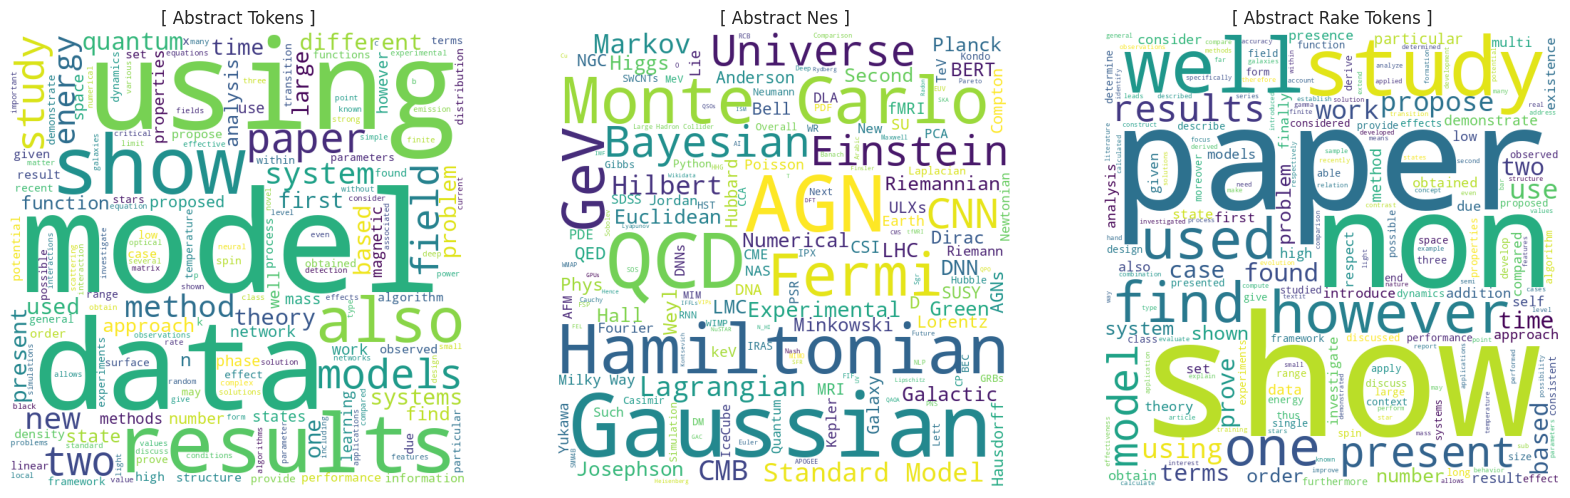

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

draw_wc(abstract_token_counts, "[ Abstract Tokens ]", axs[0])
draw_wc(abstract_nes_counts, "[ Abstract Nes ]", axs[1])
draw_wc(abstract_rakes_counts, "[ Abstract Rake Tokens ]", axs[2])

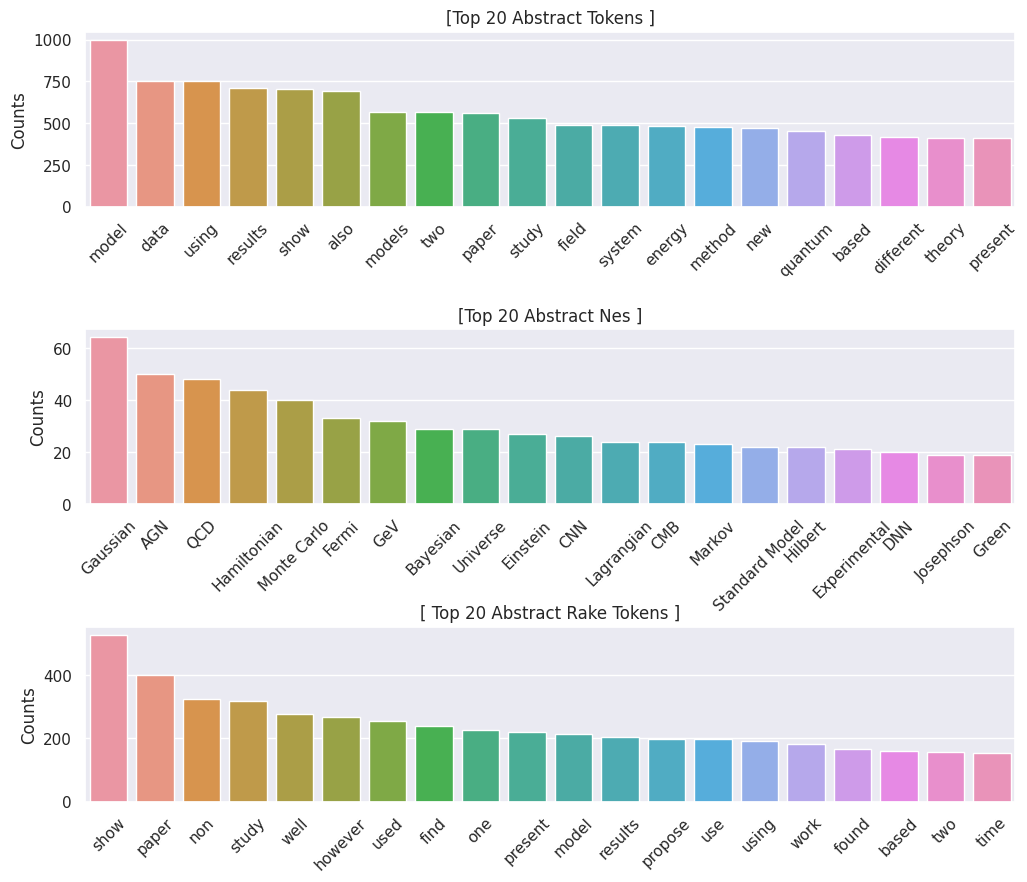

In [68]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

plot_top_10_tokens(abstract_token_counts, "[Top 20 Abstract Tokens ]", axs[0])
plot_top_10_tokens(abstract_nes_counts, "[Top 20 Abstract Nes ]", axs[1])
plot_top_10_tokens(abstract_rakes_counts, "[ Top 20 Abstract Rake Tokens ]", axs[2])

In [69]:
title_tokens_total = [token for tokens in list(arxiv_tokens_pd["title_tokens"]) for token in tokens]
title_token_counts = Counter(title_tokens_total)

title_nes_total = [token for tokens in list(arxiv_tokens_pd["title_ne"]) for token in tokens]
title_nes_counts = Counter(title_nes_total)

title_rakes_total = [token for tokens in list(arxiv_tokens_pd["title_rake_tokens"]) for token in tokens]
title_rakes_counts = Counter(title_rakes_total)

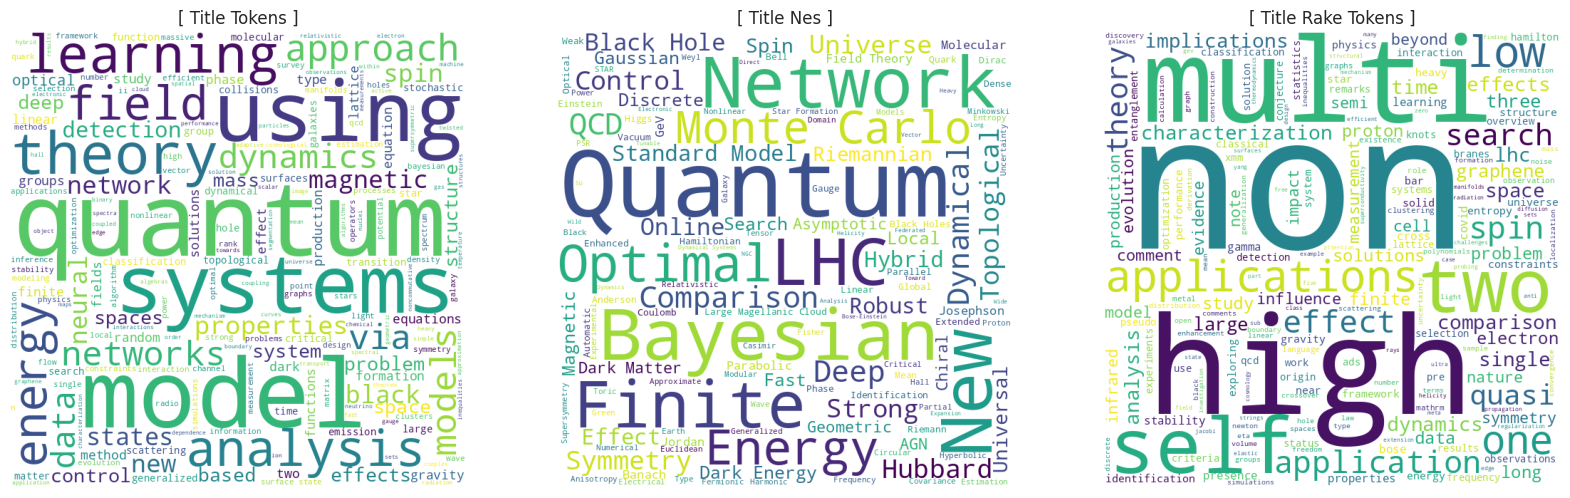

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

draw_wc(title_token_counts, "[ Title Tokens ]", axs[0])
draw_wc(title_nes_counts, "[ Title Nes ]", axs[1])
draw_wc(title_rakes_counts, "[ Title Rake Tokens ]", axs[2])

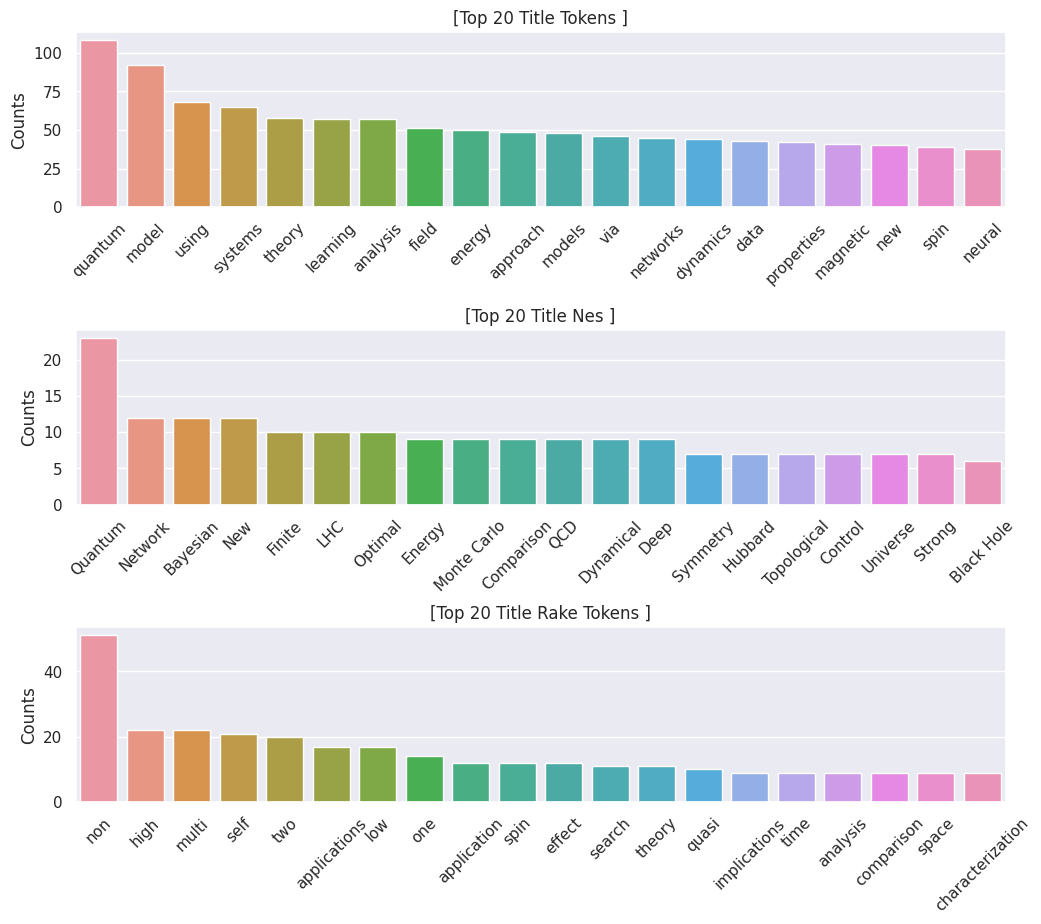

In [71]:

fig, axs = plt.subplots(3, 1, figsize=(12, 10))

plot_top_10_tokens(title_token_counts, "[Top 20 Title Tokens ]", axs[0])
plot_top_10_tokens(title_nes_counts, "[Top 20 Title Nes ]", axs[1])
plot_top_10_tokens(title_rakes_counts, "[Top 20 Title Rake Tokens ]", axs[2])

#### Token adjacency


We can now begin to join papers with one another via their shared tokens. 

In [72]:
def intersection(left, right):
    return list(set(left) & set(right))

def build_graph_df(df1 : pd.DataFrame, df2 : pd.DataFrame, token : str):
  # Merge the two DataFrames  
  product = pd.merge(df1, df2, how='cross')
  # Find the intersection of the 'title_tokens_x' and 'title_tokens_y' columns
  product[f'shared_{token}'] = product.apply(lambda row: intersection(row[f'{token}_x'], row[f'{token}_y']), axis=1)

  # Print the result
  return product[product[f"shared_{token}"].map(len) > 0]

### Benchmarking against categories

Now we're going to check how well first order BFS matching lines up with categories.

In [73]:
categories_intersect_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "categories_final")
cross_size = arxiv_tokens_pd.shape[0] ** 2
# this is the intersection of categories

#### Title tokens

We'll check title tokens first.

In [74]:
title_tokens_intersect_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "title_tokens")

In [75]:
titles_categories_pd = title_tokens_intersect_pd[["id_x", "id_y"]].merge(
    categories_intersect_pd[["id_x", "id_y"]],
    on=["id_x", "id_y"],
    indicator=True,
    how="outer"
)
titles_categories_pd.shape[0], titles_categories_pd[
    titles_categories_pd["_merge"] == "both"
].shape[0], titles_categories_pd[
    titles_categories_pd["_merge"] == "left_only"
].shape[0], titles_categories_pd[
    titles_categories_pd["_merge"] == "right_only"
].shape[0]

(1003124, 55822, 92892, 854410)

Now let's compute our confusion matrix as if the categories intersection were our labels.

In [76]:
tp = titles_categories_pd[
    titles_categories_pd["_merge"] == "both"
].shape[0]/cross_size
fp = titles_categories_pd[
    titles_categories_pd["_merge"] == "left_only"
].shape[0]/cross_size
fn = titles_categories_pd[
    titles_categories_pd["_merge"] == "right_only"
].shape[0]/cross_size
tn = 1.0 - tp - fp - fn

(tp, fp, fn, tn), (tp/(tp + fn)), (tn/(tn + fp))

((0.011085612336005541,
  0.018447291410487385,
  0.16967607817717914,
  0.8007910180763279),
 0.06132722207085666,
 0.9774823867525884)

Cool! Now we have the basis for a model with fairly high true negativity (specificity) which would be good for research. Let's see how well this works if we start to take a look at our named entities and the abstract.

#### Abstract named entities

In [77]:
abstract_ne_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "abstract_ne")

In [78]:
abstract_ne_categories_pd = abstract_ne_pd[["id_x", "id_y"]].merge(
    categories_intersect_pd[["id_x", "id_y"]],
    on=["id_x", "id_y"],
    indicator=True,
    how="outer"
)

abstract_ne_categories_pd.shape[0], abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "both"
].shape[0], abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "left_only"
].shape[0], abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "right_only"
].shape[0]

(920620, 10486, 10388, 899746)

In [79]:
tp = abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "both"
].shape[0]/cross_size
fp = abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "left_only"
].shape[0]/cross_size
fn = abstract_ne_categories_pd[
    abstract_ne_categories_pd["_merge"] == "right_only"
].shape[0]/cross_size
tn = 1.0 - tp - fp - fn

(tp, fp, fn, tn), (tp/(tp + fn)), (tn/(tn + fp))

((0.0020823999669548586,
  0.002062938285020701,
  0.17867929054622983,
  0.8171753712017946),
 0.011520139920371951,
 0.9974818825473226)

Okay, cool! Joined on named entities in the abstracts is an even more specifc model. Before we move to subcategories, let's check out a version that might perform so well. Let's do top tokens from the abstract.

#### Abstract rake

In [80]:
abstract_top_tokens_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "abstract_top_tokens")

In [81]:
abstract_top_categories_pd = abstract_top_tokens_pd[["id_x", "id_y"]].merge(
    categories_intersect_pd[["id_x", "id_y"]],
    on=["id_x", "id_y"],
    indicator=True,
    how="outer"
)

abstract_top_categories_pd.shape[0], abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "both"
].shape[0], abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "left_only"
].shape[0], abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "right_only"
].shape[0]

(1226012, 138384, 315780, 771848)

In [82]:
tp = abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "both"
].shape[0]/cross_size
fp = abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "left_only"
].shape[0]/cross_size
fn = abstract_top_categories_pd[
    abstract_top_categories_pd["_merge"] == "right_only"
].shape[0]/cross_size
tn = 1.0 - tp - fp - fn

(tp, fp, fn, tn), (tp/(tp + fn)), (tn/(tn + fp))

((0.027481483599759788,
  0.0627103053180436,
  0.1532802069134249,
  0.7565280041687718),
 0.15203156997336945,
 0.923452914015549)

That works surprisingly well! We traded true negativity for false positivy--losing specificy--as we would expect. However, overall, we're still tracking pretty well. Let's check out how this works against subcategories.

### Benchmarking against subcategories

Okay, so here is where things get a little more interesting. We'll want to watch our true positivity, it should climb a little, but we still want it to be low. If we can have high-specifity with a little bump in the true positivity, then we're on the right track. 

In [83]:
sub_categories_intersect_pd = build_graph_df(arxiv_tokens_pd, arxiv_tokens_pd, "subcategories_final")
cross_size = arxiv_tokens_pd.shape[0] ** 2

#### Abstract named entities

In [84]:
abstract_ne_sub_categories_pd = abstract_ne_pd[["id_x", "id_y"]].merge(
    sub_categories_intersect_pd[["id_x", "id_y"]],
    on=["id_x", "id_y"],
    indicator=True,
    how="outer"
)

abstract_ne_sub_categories_pd.shape[0], abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "both"
].shape[0], abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "left_only"
].shape[0], abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "right_only"
].shape[0]

(258532, 6852, 14022, 237658)

In [85]:
tp = abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "both"
].shape[0]/cross_size
fp = abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "left_only"
].shape[0]/cross_size
fn = abstract_ne_sub_categories_pd[
    abstract_ne_sub_categories_pd["_merge"] == "right_only"
].shape[0]/cross_size
tn = 1.0 - tp - fp - fn

(tp, fp, fn, tn), (tp/(tp + fn)), (tn/(tn + fp))

((0.00136072902666171,
  0.0027846092253138496,
  0.04719616739906139,
  0.948658494348963),
 0.028023393726227964,
 0.9970732782497945)

Awesome! This maintains close to the same very high specificity rate and we don't see much of a gain in true positivity, which likely indicates we're not just recommending anything in the subcategory.

We're going to move on from these exercises and start looking at some models.

## Models

### Patent data

Before we get started, let's give the patent data a similar treament to paper data. 

We'll only be keeping the abstract, the application number, and the named entity tokenization for the patents though.

In [86]:
ARXIV_IN_MEM_SAMPLE_RATE = .001

patent_tokens_sdf = train_patents_sdf.sample(ARXIV_IN_MEM_SAMPLE_RATE).select(
    [
        "application_number", "abstract"
    ]
)

In [87]:
patent_tokens_pd = pd.DataFrame.from_records(patent_tokens_sdf.collect(), columns=patent_tokens_sdf.columns)

In [100]:
patent_tokens_pd["abstract_tokens"] = patent_tokens_pd["abstract"].apply(tokenize_non_stopwords) # most expensive
patent_tokens_pd = patent_tokens_pd.dropna()

The models below adhere to the following protocol for predicting patents from papers and vice versa.

In [89]:
class Pap2Pat(Protocol):

  def train(self, *args, **kwargs):
    pass

  def charts(self, *args, **kwargs):
    pass

  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    pass

  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    pass

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    pass

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    pass


### `TokensToTokens`

In the `TokensToTokens` model, we take the same first-order BFS approach used for the papers above, and apply it to join the papers and patents, and vice versa.

In [123]:
class TokensToTokens(Pap2Pat):

  def __init__(self):

    # clean up arxiv_tokens
    self.arxiv_tokens_pd = arxiv_tokens_pd[
        ["id", "abstract_tokens"]
    ]
    self.arxiv_tokens_pd["which"] = "paper"

    # clean up papten_tokens
    self.patent_tokens_pd = patent_tokens_pd[
        ["application_number", "abstract_tokens"]
    ]
    self.patent_tokens_pd = self.patent_tokens_pd.rename({ 
        "application_number" : "id"
    })
    self.patent_tokens_pd["which"] = "patent"

  def train(self):

    combined = pd.concat([
        self.arxiv_tokens_pd,
        self.patent_tokens_pd
    ])

    self.home_table = build_graph_df(
        combined,
        combined,
        "abstract_tokens"
    )

  def charts(self):
    pass

  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    return self.home_table[
        (self.home_table["id_x"] == paper_id)
        & (self.home_table["which_y"] == "patent")
    ]


  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    print("CALLING: ", paper_id)
    return self.home_table[
        (self.home_table["id_x"] == paper_id)
        & (self.home_table["which_y"] == "paper")
    ]

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    return self.home_table[
        (self.home_table["id_x"] == patent_id)
        & (self.home_table["which_y"] == "paper")
    ]

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    return self.home_table[
        (self.home_table["id_x"] == patent_id)
        & (self.home_table["which_y"] == "patent")
    ]


In [124]:
tokens_to_tokens = TokensToTokens()


<ipython-input-123-7c8893255fbb>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.arxiv_tokens_pd["which"] = "paper"


In [125]:
tokens_to_tokens.train()

In [126]:
tokens_to_tokens.pap2pap(paper_id="0704.0092")

CALLING:  0704.0092


,id_x,abstract_tokens_x,which_x,application_number_x,id_y,abstract_tokens_y,which_y,application_number_y,shared_abstract_tokens
0,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,"[recently, study, finite, fermions, formulatio..."
1,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,0704.0427,"[study, critical, behavior, j, ising, model, p...",paper,NaN,"[study, behavior]"
2,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,0704.2537,"[masses, pseudoscalar, vector, mesons, ground,...",paper,NaN,"[energy, shown]"
3,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,0704.3268,"[easily, implementable, path, solution, algori...",paper,NaN,[shown]
4,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,0705.0252,"[consider, power, allocation, algorithms, tran...",paper,NaN,[shown]
...,...,...,...,...,...,...,...,...,...
2232,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,quant-ph/0312086,"[calculate, wigner, distribution, position, mo...",paper,NaN,"[energy, behavior, potential]"
2233,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,quant-ph/0402152,"[study, quantum, dynamics, n, coherently, driv...",paper,NaN,"[study, energy]"
2238,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,quant-ph/0505169,"[study, phenomenon, wave, packet, revivals, bl...",paper,NaN,[study]
2239,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,quant-ph/0508136,"[thermodynamical, properties, quantized, elect...",paper,NaN,"[temperature, finite, energy, density]"


In [127]:
tokens_to_tokens.pap2pat(paper_id="0704.0092")

,id_x,abstract_tokens_x,which_x,application_number_x,id_y,abstract_tokens_y,which_y,application_number_y,shared_abstract_tokens
2250,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,NaN,"[method, convert, two, dimensional, image, con...",patent,US-201414270172-A,[function]
2252,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,NaN,"[multi, axis, microelectromechanical, systems,...",patent,US-201615048763-A,[temperature]
2253,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,NaN,"[invention, relates, user, interaction, arrang...",patent,US-201213528939-A,[compute]
2262,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,NaN,"[sensor, element, detecting, physical, propert...",patent,US-201414900435-A,[overlap]
2264,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,NaN,"[method, apparatus, disclosed, monitoring, ang...",patent,US-37984099-A,[energy]
...,...,...,...,...,...,...,...,...,...
2699,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,NaN,"[exemplary, embodiments, directed, providing, ...",patent,US-86461501-A,[function]
2700,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,NaN,"[information, processing, system, configured, ...",patent,US-98784301-A,[function]
2703,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,NaN,"[analysis, tool, extracts, available, paramete...",patent,US-62400809-A,[particular]
2704,0704.0092,"[study, recently, proposed, formulation, overl...",paper,NaN,NaN,"[improved, multi, port, sram, requires, fewer,...",patent,US-12733298-A,[correct]


Now that we have our recommender, we can see that the results from joining on abstract tokens aren't all that compelling. Let's try using an embedding that someone else wrote for us.

### `SbertAvg`

In the `SbertAvg` model, we take an average of Sbert sentences embeddings and compute the cosine similarity between any two of them to produce a similarity by which be rank matching candidates.

In [186]:
class SbertAvg(Pap2Pat):

  sbert = SentenceTransformer('all-MiniLM-L6-v2')
  size : int = 10

  def __init__(self, *, size : int):
    self.size = size

    self.arxiv_pd = arxiv_tokens_pd[["id", "abstract"]].astype({
        "id" : "string",
        "abstract" : "string"
    })
    self.arxiv_pd.rename(columns={
        "id" : "id",
        "abstract" : "abstract"
    })

    self.patents_pd = patent_tokens_pd[[
        "application_number",
        "abstract"
    ]].astype({
        "application_number" : "string",
        "abstract" : "string"
    })
    self.patents_pd = self.patents_pd.rename(columns={
        "application_number" : "id",
        "abstract" : "abstract"    
    })

    self.arxiv_pd["which"] = "paper"
    self.patents_pd["which"] = "patent" 

    self.recommender_table = pd.concat([
        self.arxiv_pd,
        self.patents_pd
     ])

  def encode_text(self, text : str):

    sentences = tokenize_sentences(text)
    encoding = self.sbert.encode(sentences)
    return torch.from_numpy(np.average(encoding, axis=0))

  def train(self, *args, **kwargs):
    # just emebd all of the abstracts
    self.recommender_table["aemb"] = self.recommender_table["abstract"].apply(self.encode_text)

  
  def charts(self, *args, **kwargs):
    pass


  def compute_top_n_cosine(
      self, 
      *,
      df : pd.DataFrame, 
      id : str, 
      n : int,
      which : str
  ):

    embedding = df[df["id"]==id]["aemb"].iloc[0]
    target = df[
        (df["id"] != id)
        & (df["which"] == which)
    ]

    sim = nn.CosineSimilarity()
    values, indices = sim(
      embedding, 
      torch.stack([
        *target["aemb"].tolist()
      ])
    ).sort(descending=True)
    top_indices = indices[0:n]
    return target.iloc[top_indices]


  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=id, 
        n=self.size, 
        which="patent"
    )

  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=id, 
        n=self.size, 
        which="paper"
    )

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=id, 
        n=self.size, 
        which="paper"
    )

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=id, 
        n=self.size, 
        which="patent"
    )



In [187]:
sbert_avg = SbertAvg(size=10)

In [188]:
sbert_avg.train()

In [191]:
sbert_avg.pap2pap(paper_id="0704.0092")

,id,abstract,which,aemb
591,1502.05022,We compute the spectral density in the norma...,paper,"[tensor(-0.0846), tensor(-0.0092), tensor(0.01..."
1987,cond-mat/9807291,"In the model considered, the nonlocal intera...",paper,"[tensor(-0.0490), tensor(-0.0241), tensor(-0.0..."
565,1410.8784,We have prepared two ultracold fermionic ato...,paper,"[tensor(-0.0916), tensor(-0.0313), tensor(-0.0..."
440,1309.1111,"In the previous companion paper, we proposed...",paper,"[tensor(-0.0869), tensor(-0.0257), tensor(-0.0..."
121,0908.3812,We investigate the temperature region in whi...,paper,"[tensor(-0.0610), tensor(0.0274), tensor(-0.03..."
1968,cond-mat/0610163,A microscopic theory for electronic spectrum...,paper,"[tensor(-0.0618), tensor(0.0290), tensor(0.002..."
770,1610.03212,We derive the scattering length of composite...,paper,"[tensor(-0.0535), tensor(-0.0152), tensor(-0.0..."
1985,cond-mat/9804184,We present a lattice field theory of spins c...,paper,"[tensor(-0.0728), tensor(-0.0266), tensor(-0.0..."
1947,cond-mat/0412297,We calculate the momentum distribution and t...,paper,"[tensor(-0.0567), tensor(-0.0612), tensor(-0.0..."
1926,cond-mat/0105245,We investigate a model of excitonic ordering...,paper,"[tensor(-0.0493), tensor(-0.0309), tensor(-0.0..."


In [193]:
sbert_avg.pap2pat(paper_id="0704.0092")

,id,abstract,which,aemb
366,US-61816506-A,an electrically programmable memory cell and c...,patent,"[tensor(-0.0334), tensor(0.0086), tensor(-0.01..."
484,US-41539995-A,a thermal neutron shield for integrated circui...,patent,"[tensor(-0.0440), tensor(-0.0061), tensor(0.01..."
47,US-11351008-A,a transistor is provided that includes a silic...,patent,"[tensor(-0.0390), tensor(0.0109), tensor(0.002..."
18,US-201414900435-A,a sensor element for detecting a physical prop...,patent,"[tensor(-0.0132), tensor(0.0034), tensor(-0.02..."
340,US-65662703-A,"methods of operating surface reactors , and su...",patent,"[tensor(-0.0512), tensor(-0.0551), tensor(-0.0..."
162,US-79386985-A,a method of rapid thermal annealing a wafer of...,patent,"[tensor(-0.0418), tensor(0.0853), tensor(0.068..."
95,US-8804706-A,a method for making a thin - film element incl...,patent,"[tensor(-0.0753), tensor(0.0425), tensor(0.028..."
41,US-36525799-A,a method and apparatus for passively shimming ...,patent,"[tensor(-0.0438), tensor(0.0250), tensor(-0.00..."
27,US-94715501-A,a mosfet includes a double silicided source / ...,patent,"[tensor(-0.0602), tensor(0.0154), tensor(0.035..."
188,US-201213586288-A,"a tube comprising an inner layer , an outer la...",patent,"[tensor(-0.0581), tensor(0.0459), tensor(0.003..."


### `AhlEmbeddingAvg`

In the `AhlEmbeddingAvg`, we take the same approach as Sbert, but over our own custom ngram embeddings of both the patents and papers.

In [220]:
class AhlEmbeddingAvg(Pap2Pat):

  emebedding : Embedding
  size : int = 10
  epochs : int = 10
  embedding_dim : int = 32
  context_size : int = 2
  vocab_size : int = 2_000

  def __init__(self, *, size : int = 10):
    self.size = size

    self.arxiv_pd = arxiv_tokens_pd[["id", "abstract"]].astype({
        "id" : "string",
        "abstract" : "string"
    })
    self.arxiv_pd.rename(columns={
        "id" : "id",
        "abstract" : "abstract"
    })

    self.patents_pd = patent_tokens_pd[[
        "application_number",
        "abstract"
    ]].astype({
        "application_number" : "string",
        "abstract" : "string"
    })
    self.patents_pd = self.patents_pd.rename(columns={
        "application_number" : "id",
        "abstract" : "abstract"    
    })

    self.arxiv_pd["which"] = "paper"
    self.patents_pd["which"] = "patent" 

    self.recommender_table = pd.concat([
        self.arxiv_pd,
        self.patents_pd
     ])

  def get_vocab(self)->Vocab:
    return get_texts_vocab(
        texts=self.recommender_table["abstract"]
    )

  def yield_ngrams(self)->Iterable[Ngram]:
    for abstract in self.recommender_table["abstract"]:
      for ngram in get_text_excludes_ngrams(
        text=abstract, 
        context_size=self.context_size, 
        fill_term=""
      ):
        yield ngram


  def encode_text(self, text : str):

    embeddings = []
    for sentence in tokenize_sentences(text):
      for word in tokenize_non_stopwords(sentence):
        embeddings.append(self.embedding(word))

    return torch.mean(embeddings)

  def train(self, *args, **kwargs):
    
    # train the word embedding
    vocab = self.get_vocab()
    vocab_forward, vocab_back = vocab
    ngrams = self.yield_ngrams

    embedding, loss, weights, model = train_ngram_embedding(
        epochs=self.epochs,
        embedding_dim=self.embedding_dim,
        context_size=self.context_size*2,
        ngrams=ngrams,
        vocab=vocab
    )
    self.embedding = embedding

    # embed all of the documents
    self.recommender_table["aemb"] = self.recommender_table["aemb"].apply(self.encode_text)
  
  def charts(self, *args, **kwargs):
    pass

      
  def compute_top_n_cosine(
      self, 
      *,
      df : pd.DataFrame, 
      id : str, 
      n : int,
      which : str
  ):

    embedding = df[df["id"]==id]["aemb"].iloc[0]
    target = df[
        (df["id"] != id)
        & (df["which"] == which)
    ]

    sim = nn.CosineSimilarity()
    values, indices = sim(
      embedding, 
      torch.stack([
        *target["aemb"].tolist()
      ])
    ).sort(descending=True)
    top_indices = indices[0:n]
    return target.iloc[top_indices]


  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=id, 
        n=self.size, 
        which="patent"
    )

  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=id, 
        n=self.size, 
        which="paper"
    )

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=id, 
        n=self.size, 
        which="paper"
    )

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    return self.compute_top_n_cosine(
        df=df, 
        id=id, 
        n=self.size, 
        which="patent"
    )


In [221]:
ahl_avg = AhlEmbeddingAvg()

In [ ]:
ahl_avg.train()

### `CnnExSbert`

In [ ]:
class SbertCnn(nn.Module):
        
    def __init__(self, *, 
        text_max : int, 
        sentence_max : int, 
        layers : int, 
        embedding_size : int
    ):
        super(SbertCnn, self).__init__()
        
        self.activate = nn.Sequential(
            nn.Conv2d(layers, sentence_max, kernel_size=3, padding=1),
            nn.ReLU(), 
            nn.Conv2d(sentence_max, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Flatten(), 
            
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 384),
            nn.LeakyReLU(),
            nn.Flatten(0),
            nn.Unflatten(0, (384, 128)),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, inputs):
        return self.activate(inputs)

In [ ]:
class CnnExSbert(Pap2Pat):
  def __init__(self):
    self.arxiv_tokens_pd = arxiv_tokens_pd[
        ["id", "abstract_ne"]
    ]
    self.arxiv_tokens_pd["which"] = "paper"
    self.patent_tokens_pd = patent_tokens_pd[
        ["application_number", "abstract_ne"]
    ]
    self.patent_tokens_pd.rename({ 
        "application_number" : "id"
    })
    self.patent_tokens_pd["which"] = "patent"

  def encode_sentence(self, text : str)->torch.TensorType:
        fliced = flice_text(text, max_length=self.sentence_max, fill_str=" ")
        ascii_nums = [ord(c) for c in fliced]
        return torch.FloatTensor(ascii_nums)
    
  def encode_input(self, text : str)->torch.TensorType:
      fliced = flice_list(
          [
            self.encode_sentence(sentence)
            for sentence in tokenize_sentences(text)
          ],
          max_length=self.text_max,
          fill_term=[x for x in range(0, self.sentence_max)]
      )
  
      t = torch.stack([
          torch.FloatTensor(entry)
          for entry in fliced
      ])
      
      return torch.stack([
          t,
          torch.roll(t, 1, 0),
          torch.roll(t, -1, 0)
      ])
    
  def compute_label(self, text : str)->torch.TensorType: 
        sentences = tokenize_sentences(text)
        encoding = self.sbert.encode(sentences)
        return torch.from_numpy(np.average(encoding, axis=0))

  def train(self):

    combined = pd.concat([
        self.arxiv_tokens_pd,
        self.patent_tokens_pd
    ])

    self.recommender_table = build_graph_df(
        combined,
        combined,
        "abstract_ne"
    )

  def compute_cosine_sims(self, df : pd.DataFrame, id : str):
    sim = nn.CosineSimilarity()
    values, indices = sim(df[df["id" == id]]["aemb"].loc[0], torch.stack([
        df["aemb"]
    ])).sort(descending=True)
    return (values, indices)

  def compute_top_n_cosine(self, df : pd.DataFrame, id : str, n : int):
    values, indices = self.compute_cosine_sims(df, id)
    top_indices = indices[0:n]
    return df.iloc[top_indices]

  def pap2pat(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    df = df[
        (df["id_x"] == paper_id) 
        & (df["which_y"] == "patent")
    ]
    return self.compute_to_n_cosine(df, id, self.size)

  def pap2pap(self, *, paper_id : str)->pd.DataFrame:
    df = self.recommender_table
    df = df[
        (df["id_x"] == paper_id) 
        & (df["which_y"] == "paper")
    ]
    return self.compute_to_n_cosine(df, id, self.size)

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    df = df[
        (df["id_x"] == patent_id) 
        & (df["which_y"] == "paper")
    ]
    return self.compute_to_n_cosine(df, id, self.size)

  def pat2pap(self, *, patent_id : str)->pd.DataFrame:
    df = self.recommender_table
    df = df[
        (df["id_x"] == patent_id) 
        & (df["which_y"] == "patent")
    ]
    return self.compute_to_n_cosine(df, id, self.size)